# Train a fully connected (dense) neural network for EMNIST Digits

In [1]:
using Flux
using Statistics
using MLDatasets
using DataFrames
using OneHotArrays
using CairoMakie
using ProgressBars

## MNIST dataset

In [2]:
data = MNIST(split = :train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

### Data Exploration and Visualisation

In [3]:
data.features[:, :, 1]

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  

In [4]:
data.targets[1]

5

In [5]:
"""
    pos(v, cols)

Map an integer value to a [row, col] position in a grid of `cols` columns.
"""
function pos(v, cols)
    return mod1(v, cols), div(v - 1, cols) + 1
end;

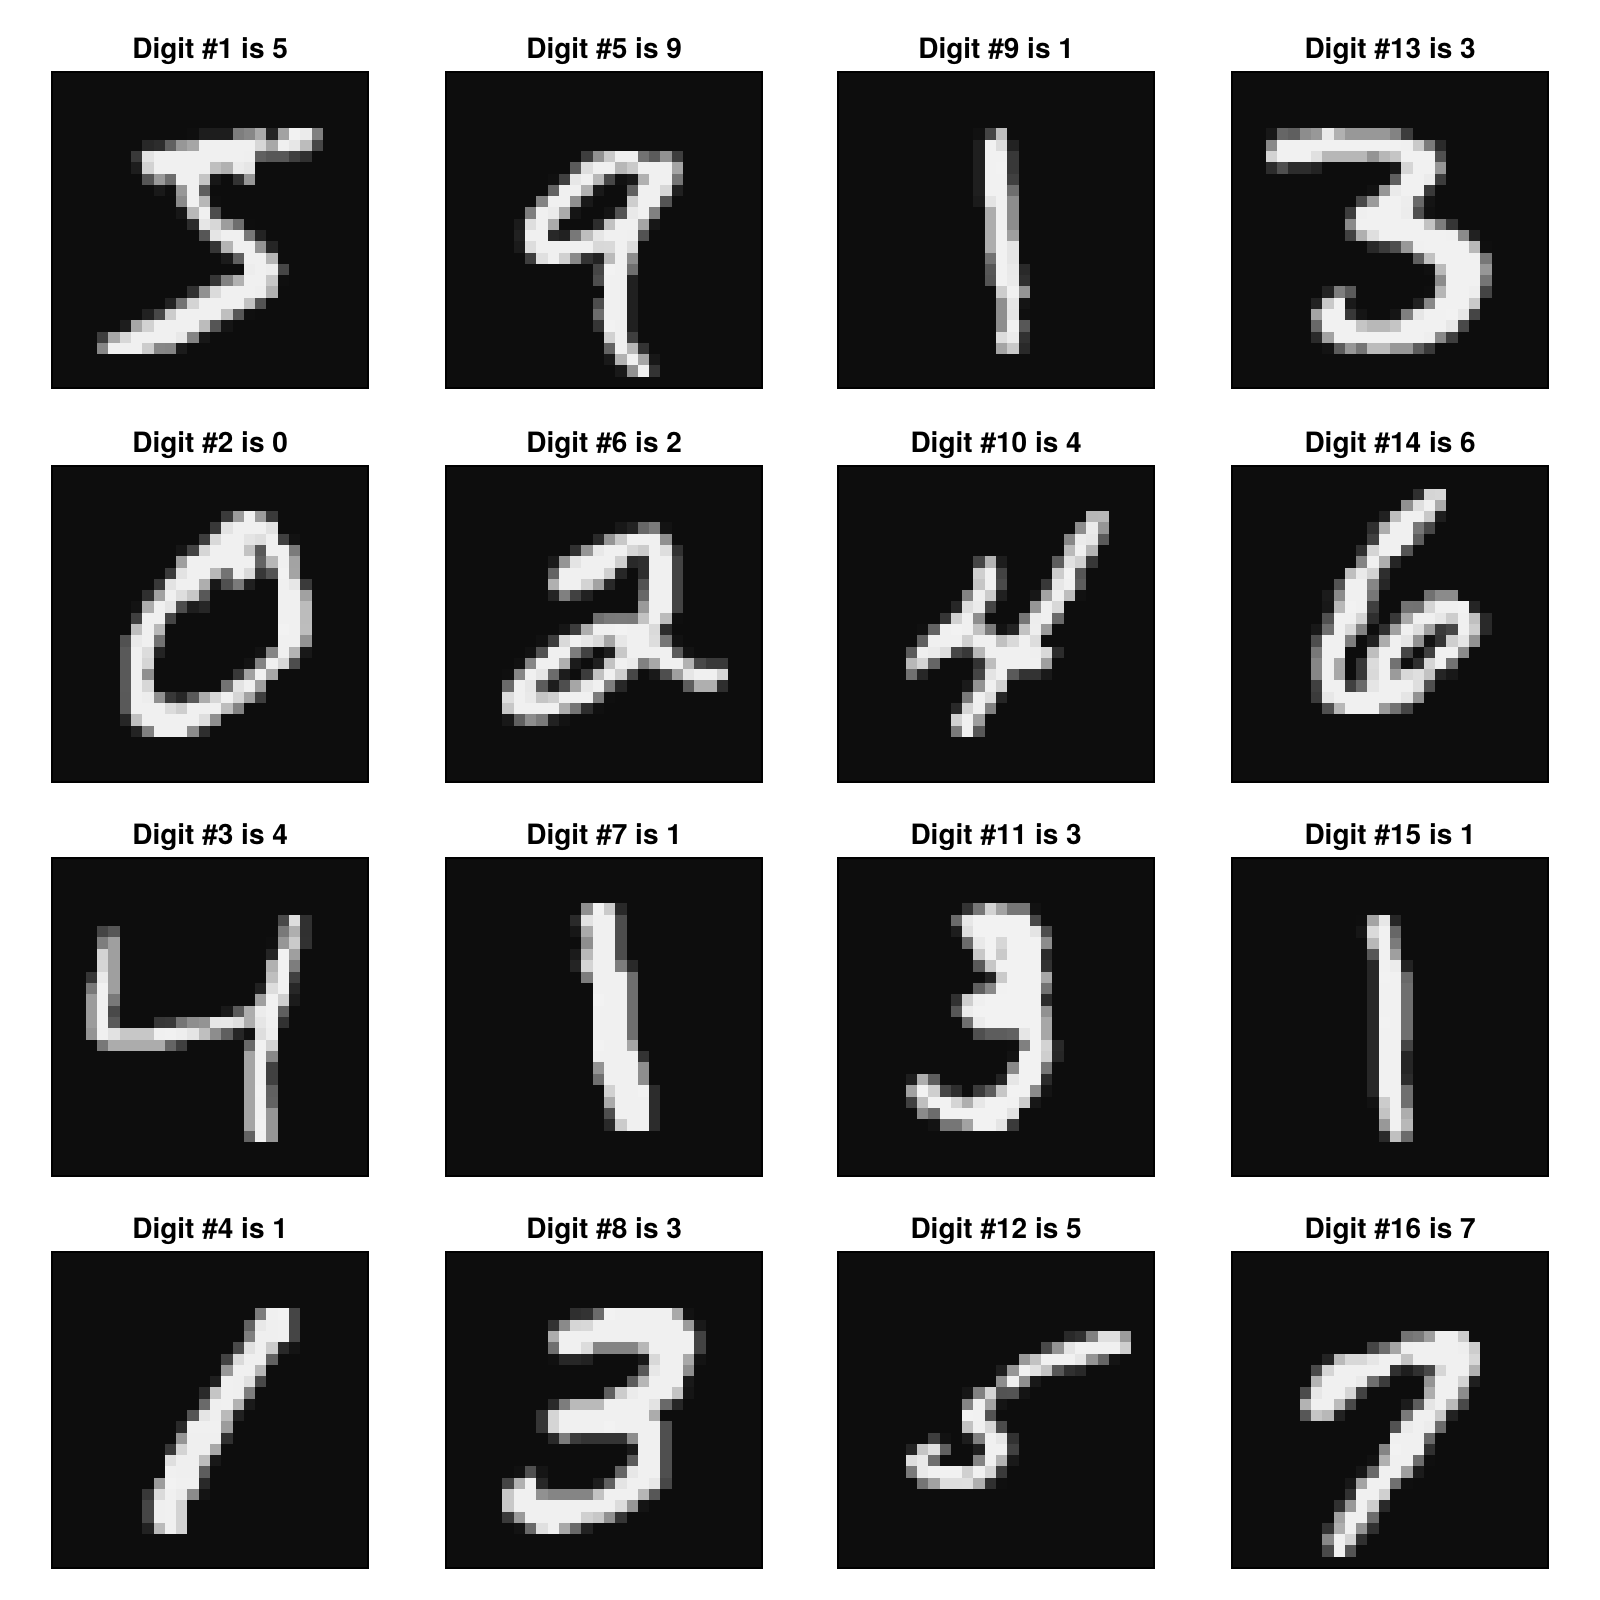

In [6]:
# Now plot a bunch of the first digits
#
# Note that the orientation is with the lowest row at the bottom of the visualisation,
# hence the `yreversed=true` in the Axis.
f = Figure(size=(800,800))
for d in 1:16
    ax = Axis(f[pos(d,4)...], aspect = DataAspect(), yreversed=true,
        title = "Digit #$d is $(Int(data.targets[d]))",)
    hidedecorations!(ax)
    heatmap!(ax, data.features[:, :, d], 
        colormap = :grays,
    )
end
f

## Network Definition

We define a network that takes the 28x28 input image array (vector of 784), passes it through two hidden layers of 1000 neurons, then the output layer is 10 neurons, passed through softmax.

In [7]:
dense_model = Chain(
    Dense(28 * 28, 1000, relu),
    Dense(1000, 1000, relu),
    Dense(1000, 10),
    softmax
)

Chain(
  Dense(784 => 1000, relu),             # 785_000 parameters
  Dense(1000 => 1000, relu),            # 1_001_000 parameters
  Dense(1000 => 10),                    # 10_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 1_796_010 parameters, 6.852 MiB.

In [8]:
dense_model(reshape(data.features[:, :, 1], (784, 1)))

10×1 Matrix{Float32}:
 0.10557136
 0.16987073
 0.07080277
 0.089716814
 0.07800847
 0.09006856
 0.11500364
 0.08613645
 0.10215866
 0.092662506

In [9]:
const classes = sort(unique(data.targets))

10-element Vector{Int64}:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [10]:
flux_y_onehot = onehotbatch(data.targets, classes)

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [11]:
flux_x = reshape(data.features, (28 * 28, size(data.features, 3)));

In [12]:
flux_data = [(flux_x, flux_y_onehot)]

1-element Vector{Tuple{Matrix{Float32}, OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0])

In [13]:
function flux_loss(flux_model, features, labels_onehot)
    ŷ = flux_model(features)
    Flux.logitcrossentropy(ŷ, labels_onehot)
end;

In [14]:
flux_loss(dense_model, flux_x, flux_y_onehot)

2.3019717f0

In [15]:
flux_accuracy(x, y) = mean(Flux.onecold(dense_model(x), classes) .== y);

In [16]:
flux_accuracy(flux_x, data.targets)

0.12973333333333334

## Training Loops

In [17]:
# Manual training function
function train_flux_model!(f_loss, model, features, labels_onehot)
    dLdm, _, _ = gradient(f_loss, model, features, labels_onehot)
    @. model[1].weight = model[1].weight - 0.1 * dLdm[:layers][1][:weight]
    @. model[1].bias = model[1].bias - 0.1 * dLdm[:layers][1][:bias]
end;
# train_flux_model!(flux_loss, dense_model, flux_x, flux_y_onehot);

train_flux_model! (generic function with 1 method)

### Loop using `train!`

In [18]:
opt_state = Flux.setup(Adam(), dense_model)
# Flux.train!(dense_model, flux_data, opt_state) do m, x, y
#     flux_loss(m, x, y)
# end

(layers = ((weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 

In [19]:
# Now run for a decent number of epochs
epochs = 100
accuracy = Vector{Float32}()
for i in ProgressBar(1:epochs)
    Flux.train!(dense_model, flux_data, opt_state) do m, x, y
        flux_loss(m, x, y)
    end
    acc = flux_accuracy(flux_x, data.targets)
    push!(accuracy, acc)
    println("Accuracy after epoch $i: $acc")
end


0.0%

Accuracy after epoch 1: 0.5407


┣                                             ┫ 0/100 [00:02<-2:-43, -2s/it]


Accuracy after epoch 2: 0.5809833333333333


1.0%┣▍                                         ┫ 1/100 [00:11<Inf:Inf, InfGs/it]


Accuracy after epoch 3: 0.6337666666666667


2.0%┣█                                             ┫ 2/100 [00:13<22:01, 13s/it]


Accuracy after epoch 4: 0.6938666666666666


3.0%┣█▍                                             ┫ 3/100 [00:16<12:59, 8s/it]


Accuracy after epoch 5: 0.7476333333333334


4.0%┣█▉                                             ┫ 4/100 [00:19<09:56, 6s/it]


Accuracy after epoch 6: 0.7710333333333333


5.0%┣██▍                                            ┫ 5/100 [00:21<08:25, 5s/it]


Accuracy after epoch 7: 0.7836833333333333


6.0%┣██▉                                            ┫ 6/100 [00:24<07:31, 5s/it]


Accuracy after epoch 8: 0.7923


7.0%┣███▎                                           ┫ 7/100 [00:27<06:51, 4s/it]


Accuracy after epoch 9: 0.8057333333333333


8.0%┣███▊                                           ┫ 8/100 [00:29<06:22, 4s/it]


Accuracy after epoch 10: 0.81915


9.0%┣████▎                                          ┫ 9/100 [00:32<06:00, 4s/it]


Accuracy after epoch 11: 0.84315


10.0%┣████▌                                        ┫ 10/100 [00:34<05:42, 4s/it]


Accuracy after epoch 12: 0.8534


11.0%┣█████                                        ┫ 11/100 [00:37<05:27, 4s/it]


Accuracy after epoch 13: 0.8689333333333333


12.0%┣█████▍                                       ┫ 12/100 [00:39<05:14, 4s/it]


Accuracy after epoch 14: 0.8719166666666667


13.0%┣█████▉                                       ┫ 13/100 [00:42<05:03, 3s/it]


Accuracy after epoch 15: 0.8838333333333334


14.0%┣██████▎                                      ┫ 14/100 [00:45<04:55, 3s/it]


Accuracy after epoch 16: 0.89005


15.0%┣██████▊                                      ┫ 15/100 [00:47<04:46, 3s/it]


Accuracy after epoch 17: 0.8976666666666666


16.0%┣███████▏                                     ┫ 16/100 [00:50<04:38, 3s/it]


Accuracy after epoch 18: 0.9012166666666667


17.0%┣███████▋                                     ┫ 17/100 [00:52<04:31, 3s/it]


Accuracy after epoch 19: 0.90235


18.0%┣████████                                     ┫ 18/100 [00:55<04:24, 3s/it]


Accuracy after epoch 20: 0.9080833333333334


19.0%┣████████▌                                    ┫ 19/100 [00:58<04:19, 3s/it]


Accuracy after epoch 21: 0.9077666666666667


20.0%┣█████████                                    ┫ 20/100 [01:00<04:13, 3s/it]


Accuracy after epoch 22: 0.9078333333333334


21.0%┣█████████▌                                   ┫ 21/100 [01:03<04:07, 3s/it]


Accuracy after epoch 23: 0.9136166666666666


22.0%┣██████████                                   ┫ 22/100 [01:05<04:02, 3s/it]


Accuracy after epoch 24: 0.9163166666666667


23.0%┣██████████▍                                  ┫ 23/100 [01:08<03:57, 3s/it]


Accuracy after epoch 25: 0.9171666666666667


24.0%┣██████████▉                                  ┫ 24/100 [01:10<03:52, 3s/it]


Accuracy after epoch 26: 0.9204666666666667


25.0%┣███████████▎                                 ┫ 25/100 [01:13<03:47, 3s/it]


Accuracy after epoch 27: 0.9226833333333333


26.0%┣███████████▊                                 ┫ 26/100 [01:15<03:43, 3s/it]


Accuracy after epoch 28: 0.9234166666666667


27.0%┣████████████▏                                ┫ 27/100 [01:18<03:39, 3s/it]


Accuracy after epoch 29: 0.9253833333333333


28.0%┣████████████▋                                ┫ 28/100 [01:21<03:35, 3s/it]


Accuracy after epoch 30: 0.92775


29.0%┣█████████████                                ┫ 29/100 [01:23<03:31, 3s/it]


Accuracy after epoch 31: 0.9282666666666667


30.0%┣█████████████▌                               ┫ 30/100 [01:26<03:26, 3s/it]


Accuracy after epoch 32: 0.92975


31.0%┣██████████████                               ┫ 31/100 [01:28<03:23, 3s/it]


Accuracy after epoch 33: 0.9317166666666666


32.0%┣██████████████▍                              ┫ 32/100 [01:31<03:19, 3s/it]


Accuracy after epoch 34: 0.9328


33.0%┣██████████████▉                              ┫ 33/100 [01:33<03:15, 3s/it]


Accuracy after epoch 35: 0.93395


34.0%┣███████████████▎                             ┫ 34/100 [01:36<03:11, 3s/it]


Accuracy after epoch 36: 0.9354166666666667


35.0%┣███████████████▊                             ┫ 35/100 [01:38<03:07, 3s/it]


Accuracy after epoch 37: 0.9366


36.0%┣████████████████▏                            ┫ 36/100 [01:40<03:04, 3s/it]


Accuracy after epoch 38: 0.9377333333333333


37.0%┣████████████████▋                            ┫ 37/100 [01:43<03:00, 3s/it]


Accuracy after epoch 39: 0.9392333333333334


38.0%┣█████████████████                            ┫ 38/100 [01:45<02:57, 3s/it]


Accuracy after epoch 40: 0.94015


39.0%┣█████████████████▌                           ┫ 39/100 [01:48<02:53, 3s/it]


Accuracy after epoch 41: 0.9408166666666666


40.0%┣██████████████████                           ┫ 40/100 [01:51<02:50, 3s/it]


Accuracy after epoch 42: 0.9421166666666667


41.0%┣██████████████████▌                          ┫ 41/100 [01:53<02:47, 3s/it]


Accuracy after epoch 43: 0.9432333333333334


42.0%┣███████████████████                          ┫ 42/100 [01:56<02:44, 3s/it]


Accuracy after epoch 44: 0.9445833333333333


43.0%┣███████████████████▍                         ┫ 43/100 [01:59<02:41, 3s/it]


Accuracy after epoch 45: 0.9456


44.0%┣███████████████████▉                         ┫ 44/100 [02:01<02:38, 3s/it]


Accuracy after epoch 46: 0.9463333333333334


45.0%┣████████████████████▎                        ┫ 45/100 [02:03<02:34, 3s/it]


Accuracy after epoch 47: 0.9470333333333333


46.0%┣████████████████████▊                        ┫ 46/100 [02:06<02:31, 3s/it]


Accuracy after epoch 48: 0.9481


47.0%┣█████████████████████▏                       ┫ 47/100 [02:09<02:28, 3s/it]


Accuracy after epoch 49: 0.9491166666666667


48.0%┣█████████████████████▋                       ┫ 48/100 [02:11<02:25, 3s/it]


Accuracy after epoch 50: 0.9498833333333333


49.0%┣██████████████████████                       ┫ 49/100 [02:13<02:22, 3s/it]


Accuracy after epoch 51: 0.9505833333333333


50.0%┣██████████████████████▌                      ┫ 50/100 [02:16<02:19, 3s/it]


Accuracy after epoch 52: 0.9513333333333334


51.0%┣███████████████████████                      ┫ 51/100 [02:19<02:16, 3s/it]


Accuracy after epoch 53: 0.9521


52.0%┣███████████████████████▍                     ┫ 52/100 [02:21<02:13, 3s/it]


Accuracy after epoch 54: 0.9529


53.0%┣███████████████████████▉                     ┫ 53/100 [02:24<02:10, 3s/it]


Accuracy after epoch 55: 0.9539333333333333


54.0%┣████████████████████████▎                    ┫ 54/100 [02:26<02:07, 3s/it]


Accuracy after epoch 56: 0.9548333333333333


55.0%┣████████████████████████▊                    ┫ 55/100 [02:29<02:04, 3s/it]


Accuracy after epoch 57: 0.95555


56.0%┣█████████████████████████▏                   ┫ 56/100 [02:31<02:01, 3s/it]


Accuracy after epoch 58: 0.9563833333333334


57.0%┣█████████████████████████▋                   ┫ 57/100 [02:34<01:58, 3s/it]


Accuracy after epoch 59: 0.9570833333333333


58.0%┣██████████████████████████                   ┫ 58/100 [02:36<01:55, 3s/it]


Accuracy after epoch 60: 0.9575166666666667


59.0%┣██████████████████████████▌                  ┫ 59/100 [02:38<01:52, 3s/it]


Accuracy after epoch 61: 0.9583166666666667


60.0%┣███████████████████████████                  ┫ 60/100 [02:41<01:49, 3s/it]


Accuracy after epoch 62: 0.9587666666666667


61.0%┣███████████████████████████▌                 ┫ 61/100 [02:43<01:46, 3s/it]


Accuracy after epoch 63: 0.9593666666666667


62.0%┣████████████████████████████                 ┫ 62/100 [02:46<01:43, 3s/it]


Accuracy after epoch 64: 0.9600333333333333


63.0%┣████████████████████████████▍                ┫ 63/100 [02:48<01:40, 3s/it]


Accuracy after epoch 65: 0.9605833333333333


64.0%┣████████████████████████████▉                ┫ 64/100 [02:51<01:38, 3s/it]


Accuracy after epoch 66: 0.9610333333333333


65.0%┣█████████████████████████████▎               ┫ 65/100 [02:53<01:35, 3s/it]


Accuracy after epoch 67: 0.9616166666666667


66.0%┣█████████████████████████████▊               ┫ 66/100 [02:56<01:32, 3s/it]


Accuracy after epoch 68: 0.9619833333333333


67.0%┣██████████████████████████████▏              ┫ 67/100 [02:58<01:29, 3s/it]


Accuracy after epoch 69: 0.9626166666666667


68.0%┣██████████████████████████████▋              ┫ 68/100 [03:01<01:26, 3s/it]


Accuracy after epoch 70: 0.96315


69.0%┣███████████████████████████████              ┫ 69/100 [03:03<01:24, 3s/it]


Accuracy after epoch 71: 0.9637666666666667


70.0%┣███████████████████████████████▌             ┫ 70/100 [03:06<01:21, 3s/it]


Accuracy after epoch 72: 0.96425


71.0%┣████████████████████████████████             ┫ 71/100 [03:09<01:18, 3s/it]


Accuracy after epoch 73: 0.96475


72.0%┣████████████████████████████████▍            ┫ 72/100 [03:12<01:16, 3s/it]


Accuracy after epoch 74: 0.9652333333333334


73.0%┣████████████████████████████████▉            ┫ 73/100 [03:14<01:13, 3s/it]


Accuracy after epoch 75: 0.9657


74.0%┣█████████████████████████████████▎           ┫ 74/100 [03:16<01:10, 3s/it]


Accuracy after epoch 76: 0.9661333333333333


75.0%┣█████████████████████████████████▊           ┫ 75/100 [03:19<01:07, 3s/it]


Accuracy after epoch 77: 0.9665166666666667


76.0%┣██████████████████████████████████▏          ┫ 76/100 [03:22<01:05, 3s/it]


Accuracy after epoch 78: 0.9669333333333333


77.0%┣██████████████████████████████████▋          ┫ 77/100 [03:25<01:02, 3s/it]


Accuracy after epoch 79: 0.9675


78.0%┣███████████████████████████████████          ┫ 78/100 [03:27<00:59, 3s/it]


Accuracy after epoch 80: 0.9680666666666666


79.0%┣███████████████████████████████████▌         ┫ 79/100 [03:30<00:57, 3s/it]


Accuracy after epoch 81: 0.9685166666666667


80.0%┣████████████████████████████████████         ┫ 80/100 [03:34<00:54, 3s/it]


Accuracy after epoch 82: 0.9689166666666666


81.0%┣████████████████████████████████████▌        ┫ 81/100 [03:37<00:51, 3s/it]


Accuracy after epoch 83: 0.9691666666666666


82.0%┣█████████████████████████████████████        ┫ 82/100 [03:40<00:49, 3s/it]


Accuracy after epoch 84: 0.9694333333333334


83.0%┣█████████████████████████████████████▍       ┫ 83/100 [03:42<00:46, 3s/it]


Accuracy after epoch 85: 0.9698166666666667


84.0%┣█████████████████████████████████████▉       ┫ 84/100 [03:45<00:43, 3s/it]


Accuracy after epoch 86: 0.9703


85.0%┣██████████████████████████████████████▎      ┫ 85/100 [03:47<00:41, 3s/it]


Accuracy after epoch 87: 0.9706166666666667


86.0%┣██████████████████████████████████████▊      ┫ 86/100 [03:50<00:38, 3s/it]


Accuracy after epoch 88: 0.9712


87.0%┣███████████████████████████████████████▏     ┫ 87/100 [03:52<00:35, 3s/it]


Accuracy after epoch 89: 0.9716166666666667


88.0%┣███████████████████████████████████████▋     ┫ 88/100 [03:55<00:32, 3s/it]


Accuracy after epoch 90: 0.9719166666666667


89.0%┣████████████████████████████████████████     ┫ 89/100 [03:58<00:30, 3s/it]


Accuracy after epoch 91: 0.9721833333333333


90.0%┣████████████████████████████████████████▌    ┫ 90/100 [04:01<00:27, 3s/it]


Accuracy after epoch 92: 0.9725166666666667


91.0%┣█████████████████████████████████████████    ┫ 91/100 [04:03<00:24, 3s/it]


Accuracy after epoch 93: 0.9729333333333333


92.0%┣█████████████████████████████████████████▍   ┫ 92/100 [04:06<00:22, 3s/it]


Accuracy after epoch 94: 0.9732


93.0%┣█████████████████████████████████████████▉   ┫ 93/100 [04:08<00:19, 3s/it]


Accuracy after epoch 95: 0.9734666666666667


94.0%┣██████████████████████████████████████████▎  ┫ 94/100 [04:11<00:16, 3s/it]


Accuracy after epoch 96: 0.97365


95.0%┣██████████████████████████████████████████▊  ┫ 95/100 [04:13<00:13, 3s/it]


Accuracy after epoch 97: 0.974


96.0%┣███████████████████████████████████████████▏ ┫ 96/100 [04:16<00:11, 3s/it]


Accuracy after epoch 98: 0.9743833333333334


97.0%┣███████████████████████████████████████████▋ ┫ 97/100 [04:18<00:08, 3s/it]


Accuracy after epoch 99: 0.9747166666666667


98.0%┣████████████████████████████████████████████ ┫ 98/100 [04:21<00:05, 3s/it]


Accuracy after epoch 100: 0.9750833333333333


99.0%┣████████████████████████████████████████████▌┫ 99/100 [04:24<00:03, 3s/it]
100.0%┣███████████████████████████████████████████┫ 100/100 [04:26<00:00, 3s/it]
100.0%┣███████████████████████████████████████████┫ 100/100 [04:26<00:00, 3s/it]


In [20]:
# # More optimal training loop
# opt_state = Flux.setup(Adam(), dense_model)

# accuracy = Vector{Float32}()
# loss = Vector{Float32}()

# for epoch in ProgressBar(1:100)
#   val, grads = Flux.withgradient(flux_loss, dense_model, flux_x, flux_y_onehot)
#   push!(loss, val)
#   Flux.update!(opt_state, dense_model, grads[1])
#   acc = flux_accuracy(dense_model, data.targets)
#   push!(accuracy, acc)
# end

#   # for (i, data) in enumerate(train_set)
#   #   input, label = data

#   #   val, grads = Flux.withgradient(model) do m
#   #     # Any code inside here is differentiated.
#   #     # Evaluation of the model and loss must be inside!
#   #     result = m(input)
#   #     flux_loss(result, label)
#   #   end

#   #   # Save the loss from the forward pass. (Done outside of gradient.)
#   #   push!(losses, val)

#   #   # Detect loss of Inf or NaN. Print a warning, and then skip update!
#   #   if !isfinite(val)
#   #     @warn "loss is $val on item $i" epoch
#   #     continue
#   #   end

#   #   Flux.update!(opt_state, model, grads[1])
#   # end

#   # # Compute some accuracy, and save details as a NamedTuple
#   # acc = my_accuracy(model, train_set)
#   # push!(my_log, (; acc, losses))

#   # # Stop training when some criterion is reached
#   # if  acc > 0.95
#   #   println("stopping after $epoch epochs")
#   #   break
#   # end
# # end

# # for i = ProgressBar(1:100)
# #     train_flux_model!(flux_loss, dense_model, flux_x, flux_y_onehot);
# #     push!(loss, flux_loss(dense_model, flux_x, flux_y_onehot))
# #     push!(accuracy, flux_accuracy(flux_x, data.targets))
# #     # flux_accuracy(flux_x, flux_y_onehot) >= 0.98 && break
# # end

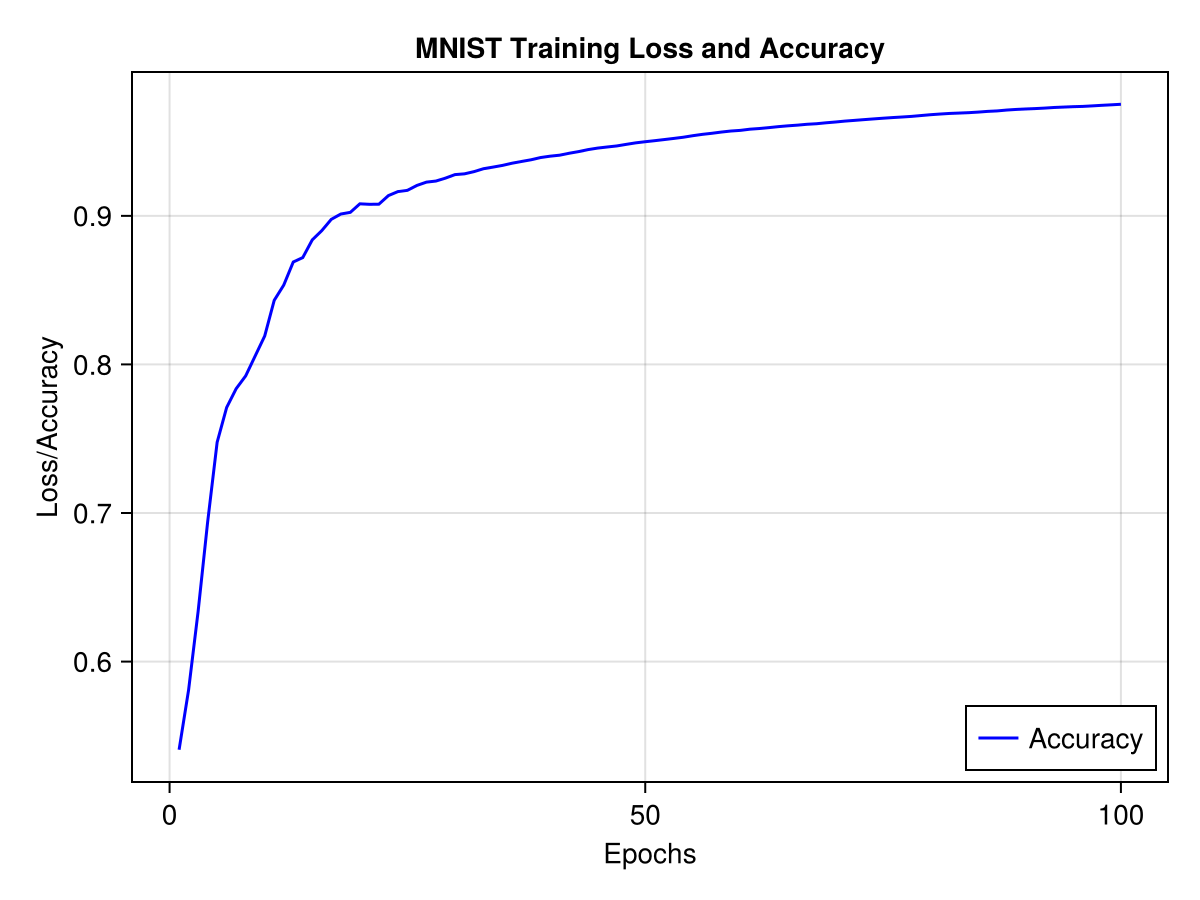

In [23]:
let 
    f = Figure()
    ax = Axis(f[1, 1],
        title = "MNIST Training Loss and Accuracy",
        xlabel = "Epochs",
        ylabel = "Loss/Accuracy",)
    epochs = collect(1:length(accuracy))
    # lines!(ax, epochs, loss, label = "Loss", color = :red)
    lines!(ax, epochs, accuracy, label = "Accuracy", color = :blue)
    axislegend(position = :rb)
    f
end